In [1]:
# Importar as bibliotecas necessárias
import os
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

# Verificar se CUDA está disponível e definir o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Definir as cores para as classes
CLASS_COLORS = { 
    'Doenca': (255, 0, 0), 
    'Saudavel': (0, 255, 0), 
    'Solo': (0, 0, 255) 
}

Usando o dispositivo: cuda


In [2]:
#definicao dos hiperparametros.
criterion = nn.CrossEntropyLoss()  # Considerando que temos múltiplas classes
learning_rate = 0.001
num_epochs = 10
patience = 30
batch_size = 4

In [3]:
# Classe do Dataset personalizado
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Modificar a extensão da máscara para '.png'
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Carregar a imagem e a máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        
        if self.transform:
            # Aplicar transformações, se houver
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Convertemos as máscaras de imagem em um array de índices de classe
        mask = self.mask_to_class(mask)
        
        return image, mask
    
    def mask_to_class(self, mask):
        # Converte a máscara para um array NumPy e ajusta para escala de 0 a 255
        mask_array = (np.array(mask, dtype=np.float32) * 255).astype(np.uint8)

        # Garantir que esté em [H, W, C]
        if mask_array.shape[0] == 3:
            mask_array = mask_array.transpose(1, 2, 0)

        mask_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.int64)

        for i, color in enumerate(CLASS_COLORS.values()):
            # Realizar comparação e detecção de igualdade entre pixels
            equal_color = np.all(mask_array == color, axis=-1)
            mask_indices[equal_color] = i

        return torch.tensor(mask_indices, dtype=torch.long)

# Função para criar transformações de dados normais e de aumento de dados
def get_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256)),  # Redimensiona para uma dimensão adequada para o modelo
        transforms.ToTensor(),  # Normaliza para [0, 1]
    ])

# Outras inicializações de datasets e dataloaders
train_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Train",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Train",
    transform=get_transforms()
)

val_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Val",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Val",
    transform=get_transforms()
)

test_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Test",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Test",
    transform=get_transforms()
)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dados carregados e preparados.")

Dados carregados e preparados.


In [ ]:
# Importar a biblioteca segmentation-models-pytorch
!pip install segmentation-models-pytorch --quiet

import segmentation_models_pytorch as smp

# Inicializar as arquiteturas dos modelos com os pesos pretreinados por padrão
unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
pspnet = smp.PSPNet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
linknet = smp.Linknet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
deeplabv3 = smp.DeepLabV3(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)

models = {
    'U-Net': unet,
    'PSPNet': pspnet,
    'LinkNet': linknet,
    'DeepLabV3': deeplabv3
}

print("Modelos configurados e prontos para treinamento.")

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modelos configurados e prontos para treinamento.


In [5]:
import torch
import torchmetrics
import numpy as np
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score, MulticlassPrecision

def compute_dice_coefficient(preds, targets):
    """
    Calcula o coeficiente de Dice
    """
    intersection = (preds * targets).sum()
    dice = (2. * intersection) / (preds.sum() + targets.sum())
    return dice.item()

def compute_aji(preds, targets):
    """
    Calcula o índice de Jaccard agregado (AJI)
    """
    preds = preds.detach().cpu().numpy().astype(np.bool_)
    targets = targets.detach().cpu().numpy().astype(np.bool_)
    
    # Calcula o Jaccard para cada componente individual nos targets/preds
    intersection = np.logical_and(preds, targets)
    union = np.logical_or(preds, targets)
    jaccard_per_class = intersection.sum() / (union.sum() + 1e-10)  # Evitar divisão por zero
    return jaccard_per_class

# Configurar as métricas, incluindo Dice e AJI personalizados
metrics = {
    'F1': MulticlassF1Score(num_classes=len(CLASS_COLORS)).to(device),
    'Jaccard': MulticlassJaccardIndex(num_classes=len(CLASS_COLORS)).to(device),
    'Precision': MulticlassPrecision(num_classes=len(CLASS_COLORS)).to(device),
    'Dice': compute_dice_coefficient,
    'AJI': compute_aji
}

In [7]:
import csv
import time
import os

# Diretório para salvar os resultados
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data"
os.makedirs(results_dir, exist_ok=True)

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, metrics, num_epochs, device, patience, model_name, results_dir):
    since = time.time()
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience_counter = 0
    epochs_run = 0  # Variável para contar as épocas realizadas

    # Variáveis para armazenar tempos de execução
    training_time = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        epochs_run += 1  # Registrar a execução da época

        epoch_start = time.time()  # Marcar o início da época

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_metrics = {key: 0 for key in metrics.keys()}
            
            for inputs, masks in tqdm(data_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                for metric_name, metric in metrics.items():
                    if metric_name in ['Dice', 'AJI']:
                        value = metric(preds, masks)
                    else:  # Para métricas torchmetrics
                        value = metric(preds, masks).item()
                    running_metrics[metric_name] += value * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_metrics = {key: value / len(data_loader.dataset) for key, value in running_metrics.items()}

            print(f'{phase} Loss: {epoch_loss:.4f}')
            for metric_name in metrics:
                print(f'{phase} {metric_name}: {epoch_metrics[metric_name]:.4f}')

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        epoch_end = time.time()  # Marcar o fim da época
        epoch_time = epoch_end - epoch_start
        training_time += epoch_time  # Acumular tempos totais
        print(f'Epoch time: {epoch_time:.2f} seconds')

        print(f'Patience counter: {patience_counter}')

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')
    print(f'Total epochs run: {epochs_run}')

    # Restaurar o melhor modelo
    model.load_state_dict(best_model_wts)

    # Salvar o modelo treinado
    model_path = os.path.join(results_dir, f'{model_name}_best.pth')
    torch.save(model.state_dict(), model_path)

    # Coletar as métricas finais
    final_metrics = epoch_metrics
    final_metrics['best_loss'] = best_loss
    final_metrics['training_time'] = time_elapsed
    final_metrics['epochs_run'] = epochs_run

    # Salvar todas as métricas para CSV
    csv_path = os.path.join(results_dir, 'results.csv')
    write_metrics_to_csv(csv_path, model_name, final_metrics)

    return model

def write_metrics_to_csv(csv_path, model_name, metrics):
    headers = ['nome', 'f1-score', 'indice jaccard', 'precision', 'dice', 'aji', 'best_loss', 'training_time', 'epochs_run']
    row = [
        model_name,
        metrics['F1'],
        metrics['Jaccard'],
        metrics['Precision'],
        metrics['Dice'],
        metrics['AJI'],
        metrics['best_loss'],
        metrics['training_time'],
        metrics['epochs_run']
    ]

    file_exists = os.path.isfile(csv_path)

    with open(csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)  # Escrever cabeçalhos se o arquivo não existe
        writer.writerow(row)  # Salvar linha de métricas

# Definir um otimizador para cada modelo
optimizers = {
    model_name: torch.optim.Adam(model.parameters(), lr=learning_rate) 
    for model_name, model in models.items()
}

# Executar o Treinamento dos Modelos
for model_name, model in models.items():
    print("*********************************************************************")
    print(f"Treinando {model_name} com early stopping.")
    trained_model = train_model_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizers[model_name],
        metrics=metrics,
        num_epochs=num_epochs,
        device=device,
        patience=patience,
        model_name=model_name,
        results_dir=results_dir
    )
    print(f'{model_name} treinado e salvo com sucesso.')

print("Treinamento completo de todos os modelos com early stopping.")

*********************************************************************
Treinando DeepLabV3 com early stopping.
Epoch 1/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


train Loss: 1.0552
train F1: 0.4626
train Jaccard: 0.3226
train Precision: 0.5152
train Dice: 1.0359
train AJI: 0.3931


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 1.3238
val F1: 0.3058
val Jaccard: 0.1889
val Precision: 0.4670
val Dice: 0.8153
val AJI: 0.4278
Epoch time: 25.60 seconds
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.7198
train F1: 0.6182
train Jaccard: 0.4671
train Precision: 0.6758
train Dice: 1.2699
train AJI: 0.4904


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 1.1667
val F1: 0.4512
val Jaccard: 0.3224
val Precision: 0.5543
val Dice: 1.2574
val AJI: 0.5435
Epoch time: 24.42 seconds
Patience counter: 0
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.6001
train F1: 0.6879
train Jaccard: 0.5442
train Precision: 0.7177
train Dice: 1.4135
train AJI: 0.5774


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


val Loss: 0.7488
val F1: 0.6071
val Jaccard: 0.4680
val Precision: 0.6308
val Dice: 1.2899
val AJI: 0.5741
Epoch time: 24.50 seconds
Patience counter: 0
Epoch 4/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


train Loss: 0.5515
train F1: 0.7304
train Jaccard: 0.5901
train Precision: 0.7414
train Dice: 1.4278
train AJI: 0.6255


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.5692
val F1: 0.6470
val Jaccard: 0.5135
val Precision: 0.6835
val Dice: 1.4059
val AJI: 0.5839
Epoch time: 24.23 seconds
Patience counter: 0
Epoch 5/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


train Loss: 0.4762
train F1: 0.7741
train Jaccard: 0.6407
train Precision: 0.7789
train Dice: 1.4459
train AJI: 0.6619


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.5872
val F1: 0.6702
val Jaccard: 0.5577
val Precision: 0.6779
val Dice: 1.4666
val AJI: 0.6057
Epoch time: 24.21 seconds
Patience counter: 1
Epoch 6/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.4422
train F1: 0.7898
train Jaccard: 0.6629
train Precision: 0.7976
train Dice: 1.5059
train AJI: 0.6858


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.5078
val F1: 0.6625
val Jaccard: 0.5543
val Precision: 0.6795
val Dice: 1.4650
val AJI: 0.6090
Epoch time: 24.33 seconds
Patience counter: 0
Epoch 7/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.3606
train F1: 0.8367
train Jaccard: 0.7261
train Precision: 0.8316
train Dice: 1.5426
train AJI: 0.7475


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.6842
val F1: 0.6373
val Jaccard: 0.5357
val Precision: 0.8145
val Dice: 1.3611
val AJI: 0.5154
Epoch time: 24.26 seconds
Patience counter: 1
Epoch 8/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.3809
train F1: 0.8224
train Jaccard: 0.7092
train Precision: 0.8177
train Dice: 1.5350
train AJI: 0.7398


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.6301
val F1: 0.6437
val Jaccard: 0.5158
val Precision: 0.6787
val Dice: 1.3543
val AJI: 0.6059
Epoch time: 24.32 seconds
Patience counter: 2
Epoch 9/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.3434
train F1: 0.8427
train Jaccard: 0.7349
train Precision: 0.8485
train Dice: 1.5612
train AJI: 0.7540


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.4338
val F1: 0.7028
val Jaccard: 0.5910
val Precision: 0.7157
val Dice: 1.4896
val AJI: 0.6823
Epoch time: 24.48 seconds
Patience counter: 0
Epoch 10/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.2979
train F1: 0.8682
train Jaccard: 0.7713
train Precision: 0.8635
train Dice: 1.5669
train AJI: 0.7883


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

val Loss: 0.4270
val F1: 0.7378
val Jaccard: 0.6251
val Precision: 0.7669
val Dice: 1.4700
val AJI: 0.6731
Epoch time: 24.39 seconds
Patience counter: 0
Training complete in 4m 5s
Best val loss: 0.4270
Total epochs run: 10
DeepLabV3 treinado e salvo com sucesso.
Treinamento completo de todos os modelos com early stopping.


C:\Users\Henrique Moreira\AppData\Local\Temp\ipykernel_16020\2253927742.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(trained

Visualizando e salvando predições para DeepLabV3...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


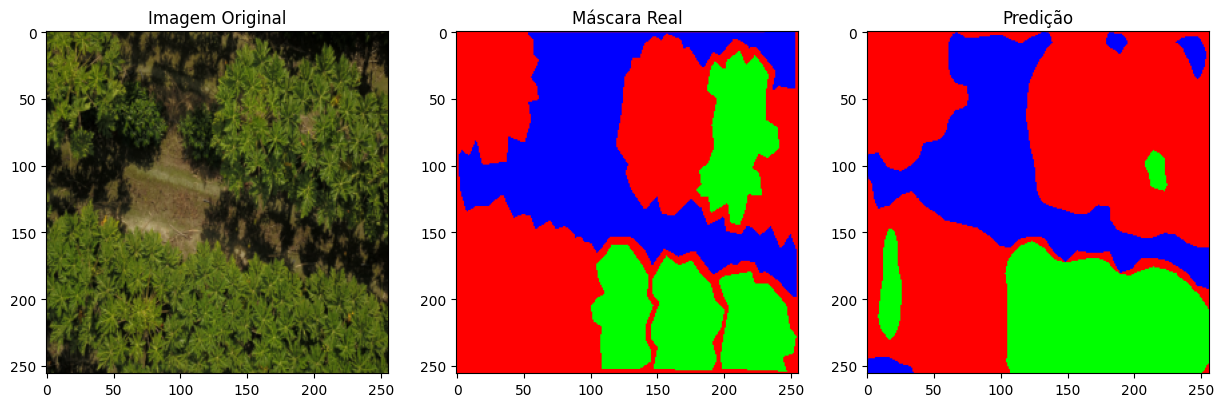

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


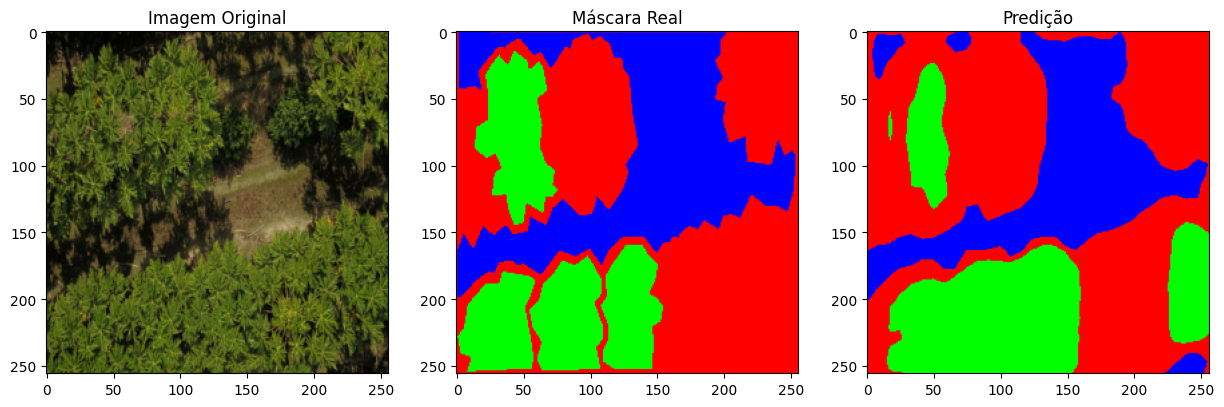

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


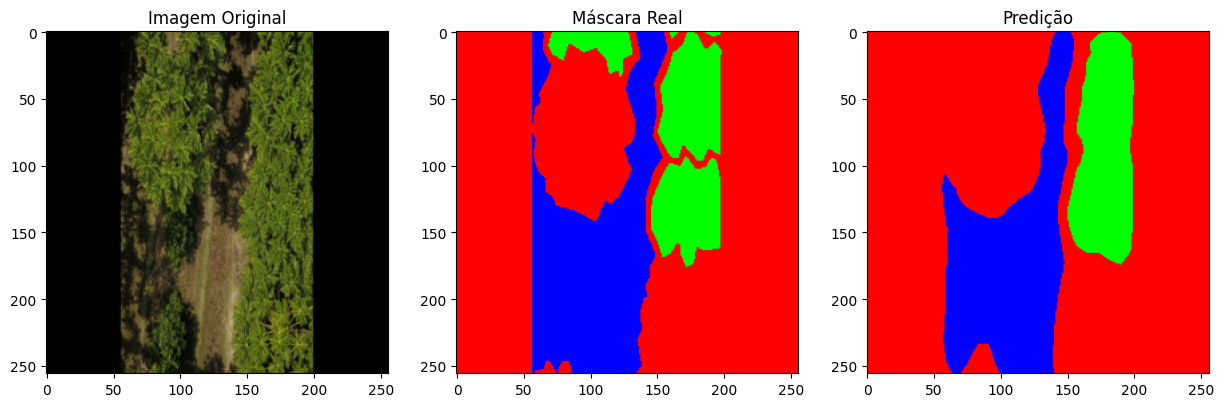

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


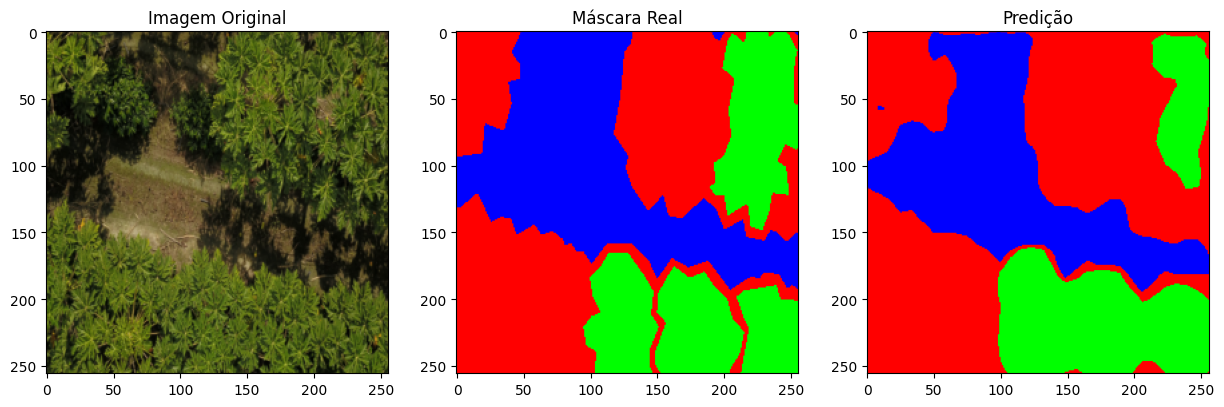

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


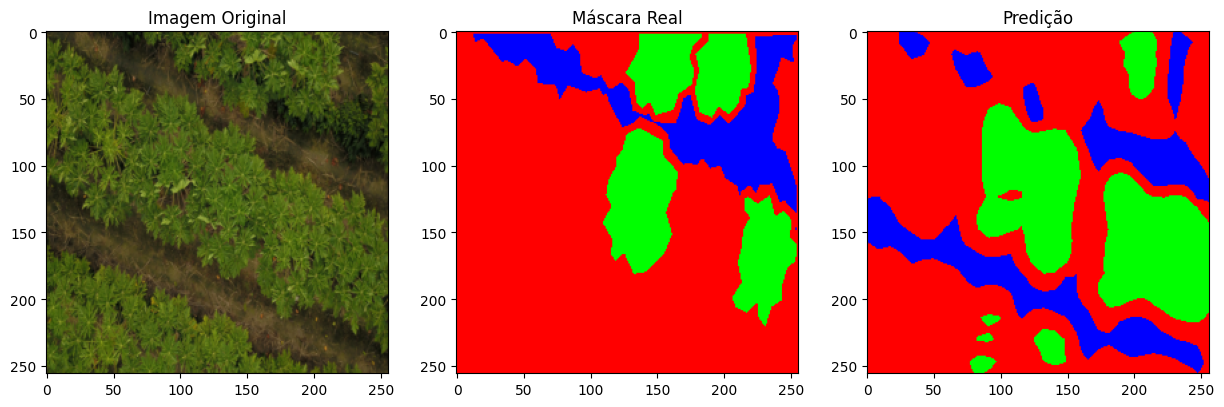

Visualização e salvamento concluídos!


In [8]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Diretório para salvar os resultados das imagens
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/images"
os.makedirs(results_dir, exist_ok=True)

# Diretório onde os arquivos do modelo foram salvados
model_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data" 

# Função auxiliar para transformar índices de classe em cores RGB
def class_to_rgb(mask_indices):
    mask_rgb = np.zeros((mask_indices.shape[0], mask_indices.shape[1], 3), dtype=np.uint8)
    unique_classes = np.unique(mask_indices)
    print(f"Unique classes in mask: {unique_classes}")  # Log para classes únicas

    for class_index, color in enumerate(CLASS_COLORS.values()):
        mask_rgb[mask_indices == class_index] = color
        print(f"Mapping class {class_index} to color {color}")  # Log para mapeamento
    return mask_rgb

# Função para visualizar e salvar predições
def visualize_and_save_predictions(model, data_loader, device, results_dir, model_name, num_images=5):
    model.eval()
    images_saved = 0

    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                images_saved += 1
                if images_saved > num_images:
                    return
                
                # Processamento para visualização
                image = (inputs[i].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                
                # Conversão de índices para RGB
                mask = class_to_rgb(masks[i].cpu().numpy())
                prediction = class_to_rgb(preds[i].cpu().numpy())

                # Logs para depuração
                print(f"Input shape: {inputs[i].shape}")
                print(f"Mask shape: {masks[i].shape}")
                print(f"Prediction shape: {preds[i].shape}")

                # Visualização
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Imagem Original')

                plt.subplot(1, 3, 2)
                plt.imshow(mask)
                plt.title('Máscara Real')

                plt.subplot(1, 3, 3)
                plt.imshow(prediction)
                plt.title('Predição')

                plt.show()
                
                # Salvar as imagens
                plt.imsave(os.path.join(results_dir, f'{model_name}_input_{images_saved}.png'), image)
                plt.imsave(os.path.join(results_dir, f'{model_name}_mask_{images_saved}.png'), mask)
                plt.imsave(os.path.join(results_dir, f'{model_name}_prediction_{images_saved}.png'), prediction)

# Executar para cada modelo
for model_name, model in models.items():
    print(f"Visualizando e salvando predições para {model_name}...")
    
    trained_model = model
    trained_model_path = os.path.join(model_dir, f'{model_name}_best.pth')
    trained_model.load_state_dict(torch.load(trained_model_path))
    trained_model.to(device)
    
    visualize_and_save_predictions(trained_model, test_loader, device, results_dir, model_name, num_images=5)

print("Visualização e salvamento concluídos!")